# Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
import os
import lib.data_loader as data_loader
import models.base_model as base_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import matplotlib.image as mpimg
# from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import random, os
import numpy as np
import pandas as pd
# import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
#%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from glob import glob
import gc
# from skimage.transform import resize

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed

from sklearn.metrics import f1_score, recall_score, precision_score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
#! pip install -q -U keras-tuner
import keras_tuner as kt

import json

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.0
Train model
Tensorflow version 2.4.0


# Data

In [4]:
train_generators, valid_generators, test_generators, test = data_loader.load_all("deep_augment")


Import train and test data

Doing a light data augmentation

Create training, validation and test set

Found 33047 validated image filenames.
Found 3761 validated image filenames.
Found 3197 validated image filenames.
Data munging completed


# Fine tuning

In [5]:
def model_builder_cnn(hp, conv_dropout=True):

    #########################################
    ## set hyperparameters for fine tuning ##
    #########################################

    # tune the number of units
    hp_units = hp.Int('units', min_value=32, max_value=32*8, step=32)
    
    # tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    # convulational layers
    conv_layers = hp.Int('conv_blocks', 2, 5, default=3)

    # dropour rate
    dropout_rate = hp.Float('dropout', 0, 0.5, step=0.1, default=0.2)

    np.random.seed(1000) # Define the seed for numpy to have reproducible experiments.
    set_seed(150) # Define the seed for Tensorflow to have reproducible experiments.

    ###################
    ## define model ##
    ###################
    input_shape = (320,320,3)
    
    # define the input layer
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    # define the convolutional layers
    # using functional api
    for i in range(conv_layers):
        # filters
        filters = hp.Int('filters_' + str(i), 32, 224, step=32)

        x = Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=tf.keras.layers.ReLU(),
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)

        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)

        if conv_dropout:
            x = Dropout(
                rate = dropout_rate,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)

    # flatten the convolved images 
    # fit to feed the dense layer
    x = Flatten(name='Flatten')(x)
    
    # define the output layer
    output = Dense(
        units = classes,
        activation = 'softmax',
        name='Output'
    )(x)

    # define the model and train it
    model_cnn = Model(inputs=input, 
                      outputs=output)

    model_cnn.compile(
                      optimizer=optimizer, 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])
    
    return model_cnn
    

In [6]:
# build tuner to fine-tune the hyper-parameters
# for the model
classes=14
tuner = kt.Hyperband(
                    model_builder_cnn,
                    objective='val_accuracy',
                    max_epochs=30,
                    hyperband_iterations=2,
                    directory='data/fine_tuner_1stproject',
                    project_name='base_model_30_epochs'
)

INFO:tensorflow:Reloading Oracle from existing project data/fine_tuner_1stproject/base_model_30_epochs/oracle.json
INFO:tensorflow:Reloading Tuner from data/fine_tuner_1stproject/base_model_30_epochs/tuner0.json


In [ ]:
# define the early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=5)

# perfrom search for best parameters
tuner.search(train_generators, 
             validation_data=valid_generators, 
             epochs=30, 
             callbacks=[stop_early],
             validation_steps=4,
             steps_per_epoch=10)

# get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 160 Complete [00h 07m 26s]
val_accuracy: 0.1796875

Best val_accuracy So Far: 0.375
Total elapsed time: 01h 34m 19s

Search: Running Trial #161

Value             |Best Value So Far |Hyperparameter
128               |160               |units
0.0001            |0.001             |learning_rate
4                 |4                 |conv_blocks
0.1               |0                 |dropout
224               |160               |filters_0
160               |160               |filters_1
96                |64                |filters_2
32                |160               |filters_3
128               |None              |filters_4
10                |30                |tuner/epochs
4                 |10                |tuner/initial_epoch
2                 |3                 |tuner/bracket
1                 |3                 |tuner/round
0154              |0047              |tuner/trial_id

Epoch 5/10
10/10 [==============================] - 182s 18s/step - loss: 2.6199 - accuracy: 0.0726

In [7]:
# define the early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=5)

# perfrom search for best parameters
tuner.search(train_generators, 
             validation_data=valid_generators, 
             epochs=30, 
             callbacks=[stop_early],
             validation_steps=4,
             steps_per_epoch=10)

# get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 180 Complete [01h 08m 25s]
val_accuracy: 0.34375

Best val_accuracy So Far: 0.40625
Total elapsed time: 09h 56m 27s
INFO:tensorflow:Oracle triggered exit


In [8]:
print('Units: ',best_hps.get('units'), ', Learning rate: ', best_hps.get('learning_rate'), ', Convolutional blocks: ', best_hps.get('conv_blocks'), ', Dropout rate: ', best_hps.get('dropout'))

Units:  96 , Learning rate:  0.0001 , Convolutional blocks:  2 , Dropout rate:  0.0


In [5]:
# build model based on the hparams

def architecture_model(input_shape,
                conv_layers,
                conv_activation,
                conv_dropout,
                units,
                output_activation,
                optimizer,
                loss,
                metrics,
                verbose=1):
    
    np.random.seed(1234) # Define the seed for numpy to have reproducible experiments.
    set_seed(9876) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=8*(2**(i+1)),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=0.2,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Define the output layer.
    output = Dense(
        units=units,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, 
                  outputs=output)
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    # print summary and architecture
    model.summary()

    return model

# Best model

## Build

In [6]:
# Units:  96 , 
#     Learning rate:  0.0001 , 
#         Convolutional blocks:  2 , 
#             Dropout rate:  0.0

In [7]:
model = architecture_model(input_shape = (320,320,3),
                        conv_layers = 2,
                        conv_activation = 'relu',
                        conv_dropout = 0,
                        units = 14,
                        output_activation = 'softmax',
                        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss = 'sparse_categorical_crossentropy',
                        metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 160, 160, 16)      0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 160, 160, 32)      4640      
_________________________________________________________________
MaxPool2D-2 (MaxPooling2D)   (None, 80, 80, 32)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
Output (Dense)               (None, 14)                286721

In [9]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                             patience=8,
                                             restore_best_weights=True)
    
validation_steps = math.ceil(valid_generators.n/ (4*valid_generators.batch_size))
print("Using validation_steps = %d" % validation_steps)
steps_per_epoch = math.ceil(train_generators.n / (8*train_generators.batch_size))
print("Using steps_per_epoch = %d" % steps_per_epoch)

history = model.fit(train_generators,
                    validation_data = valid_generators,
                    validation_steps = validation_steps,
                    steps_per_epoch = steps_per_epoch,
                    epochs=50,
                    verbose=1,
                    callbacks=[callbacks]
)

Using validation_steps = 30
Using steps_per_epoch = 130


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
130/130 [==============================] - 106s 811ms/step - loss: 2.4480 - accuracy: 0.1732 - val_loss: 2.2707 - val_accuracy: 0.2531
Epoch 2/50
130/130 [==============================] - 108s 827ms/step - loss: 2.2559 - accuracy: 0.2651 - val_loss: 2.0787 - val_accuracy: 0.3240
Epoch 3/50
130/130 [==============================] - 106s 808ms/step - loss: 2.1146 - accuracy: 0.2992 - val_loss: 1.9832 - val_accuracy: 0.3385
Epoch 4/50
130/130 [==============================] - 102s 780ms/step - loss: 2.0239 - accuracy: 0.3238 - val_loss: 2.0387 - val_accuracy: 0.3250
Epoch 5/50
130/130 [==============================] - 106s 809ms/step - loss: 1.9315 - accuracy: 0.3371 - val_loss: 1.9320 - val_accuracy: 0.3719
Epoch 6/50
130/130 [==============================] - 100s 762ms/step - loss: 1.9299 - accuracy: 0.3448 - val_loss: 1.9121 - val_accuracy: 0.3604
Epoch 7/50
130/130 [==============================] - 106s 808ms/step - loss: 1.9397 - accuracy: 0.3640 - val_loss: 1.9583 -

In [11]:
# save model

model.save("data/models/finetuned_deep_augment_14classes_50epochs.h5")
import json
with open("data/history/history_finetuned_deep_augment_14classes_50epochs.json", "w") as file:
    json.dump(history.history, file)

## Plots

In [10]:
import lib.plot_learning_curves as plot_learning_curves

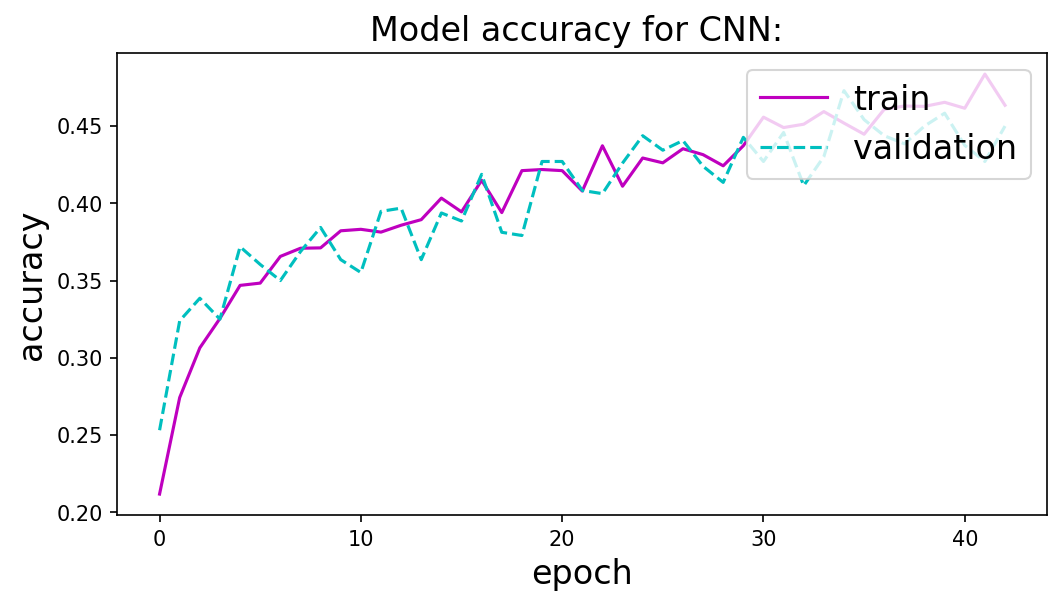

<Figure size 640x480 with 0 Axes>

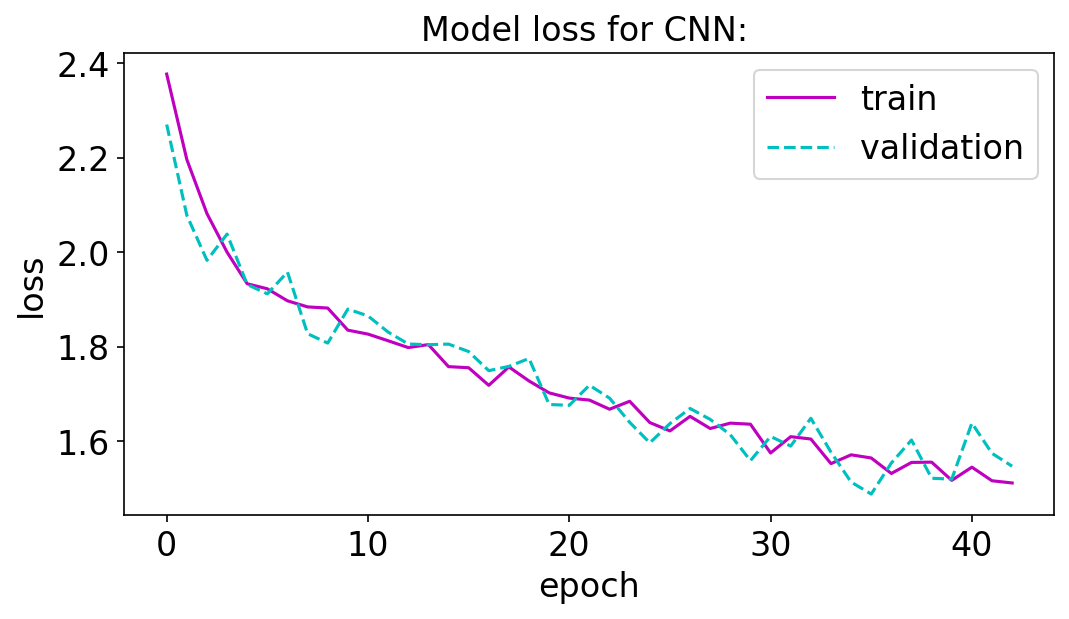

In [13]:
plot_learning_curves.plot_history_all(history,
                 'based_model_finetuned',
                50,
                'deep_augment')

## Evaluate

In [14]:
# evaluate the model
eval_result1 = model.evaluate(test_generators)
print("[test loss, test accuracy]:", eval_result1)
eval_result2 = model.evaluate(train_generators)
print("[train loss, train accuracy]:", eval_result2)
eval_result3 = model.evaluate(valid_generators)
print("[valid loss, valid accuracy]:", eval_result3)

100/100 [==============================] - 17s 169ms/step - loss: 1.8003 - accuracy: 0.3675
[test loss, test accuracy]: [1.8003240823745728, 0.36753207445144653]
1033/1033 [==============================] - 655s 634ms/step - loss: 1.5618 - accuracy: 0.4531
[train loss, train accuracy]: [1.5618151426315308, 0.45311224460601807]
118/118 [==============================] - 19s 162ms/step - loss: 1.5623 - accuracy: 0.4634
[valid loss, valid accuracy]: [1.5622568130493164, 0.46344056725502014]


In [20]:
def eval_func_multi(y_true, y_prob):
    """
    A function calculating the different evaluation metrics on the test set.
    Converts prediction probabilities y_prob to predicted labels y_pred
    """
    y_pred = np.array(y_prob)
    y_true = np.array(y_true)

    print(f"Test accuracy: {round(accuracy_score(y_true, y_pred)*100, 2)} %")
    print(f"Test F1 score: {round(f1_score(y_true, y_pred)*100, 2)} %")
    print(f"Test Precision score: {round(precision_score(y_true, y_pred)*100, 2)} %")
    print(f"Test Recall score: {round(recall_score(y_true, y_pred)*100, 2)} %")

In [22]:
# eval_func_multi(test['new_class'], 
#           model.predict(test_generators))

## Prediction

In [23]:
# # obtaining predictions for mode
# from sklearn.metrics import classification_report

# # test set
# predictions_test = model.predict(test_generators)

# def round_predictions(predictions):
#   return [round(item) for item in predictions]

# predictions_test = [round_predictions(item) for item in predictions_test]

# predictions_test=np.array(predictions_test)

# report_test  = classification_report(test['new_class'], 
#                                      predictions_test, 
#                                      output_dict=True)

# import pprint
# pp = pprint.PrettyPrinter(indent=2)
# pp.pprint(report_test)

In [24]:
# # make dataframe

# import pandas as pd

# report_test_df = pd.DataFrame(report_test)
# round(report_test_df*100, 2)

In [25]:
# # export for latex

# print(round(report_test_df*100, 2).to_latex(index=False))  